In [7]:
# Tutorials from which we took some code (adapted):
# - https://nextjournal.com/gkoehler/pytorch-mnist
# - https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

In [8]:
# Set constants
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 1000 # I don't think this actually matters

NUMBER_OF_EPOCHS = 10   
LEARNING_RATE = 0.1
MOMENTUM = 0

USE_PNG_FORMAT = False

In [9]:
import exercise2_config as config
import torch
import numpy as np
import pandas as pd
import os
from datetime import datetime
from PIL import Image


torch.backends.cudnn.enabled = False
seed = round(datetime.timestamp(datetime.now()))
torch.manual_seed(seed)

print(f'Seed = {seed}')


def ReadImages(dir):
  images = []
  for filename in os.listdir(dir):
    image_path = os.path.join(dir, filename)
    image = Image.open(image_path)
    image_as_array = np.array(image.getdata())
    images.append(image_as_array)
    return images


def BuildDataLoadersFromPngFiles():
  for label in range(10):
    dir = os.path.join(config.PNG_TRAIN_DATA_DIR, f'{label}')
    images = ReadImages(dir)
    print(images[0])
    input()

  pass


def BuildDataLoadersFromCsvFiles():
  train_images = pd.read_csv(config.TRAIN_DATA_FILE, header=None)
  test_images = pd.read_csv(config.TEST_DATA_FILE, header=None)

  train_data = np.array(train_images.iloc[:,1:])
  train_labels = np.array(train_images.iloc[:,0])
  test_data = np.array(test_images.iloc[:,1:])
  test_labels = np.array(test_images.iloc[:,0])

  train_data = np.reshape(train_data, (len(train_data), 1, 28, 28))
  # Normalize the data
  train_data = torch.from_numpy(train_data).float()/255
  train_labels = torch.from_numpy(np.array(train_labels))
  train_set = torch.utils.data.TensorDataset(train_data, train_labels)

  test_data = np.reshape(test_data, (len(test_data), 1, 28, 28))
  # Normalize the data
  test_data = torch.from_numpy(test_data).float()/255
  test_labels = torch.from_numpy(np.array(test_labels))
  test_set = torch.utils.data.TensorDataset(test_data, test_labels)
  
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
  return train_loader, test_loader


# We first import the data and convert them to a torch version
def BuildDataLoaders(use_png_format=USE_PNG_FORMAT):
  if use_png_format:
    return BuildDataLoadersFromPngFiles()
  return BuildDataLoadersFromCsvFiles()


train_loader, test_loader = BuildDataLoaders()


Seed = 1649183043


In [10]:
%load_ext autoreload
%autoreload 2
import model_task2c
import torch.nn.functional as F


# Something is not quite right and the values become nan
torch.autograd.set_detect_anomaly(True) 


# Initialize classifier stuff
cnn_model = model_task2c.PR_CNN()   # initialization of the model
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#To optimize the learning rate with LambdaLR
#From https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
lambda1 = lambda factor: 0.85 ** factor
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
for i in range(10):
    optimizer.step()
    print("Factor = ", round(0.85 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
    scheduler.step()
    
print(cnn_model)


# Compute the accuracy of the model on the given data set 
# and returns the loss. 
def ComputeAccuracy(loader, data_label, loss_func='cross_entropy'):
    cnn_model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for _, (data, label) in enumerate(loader):
            output = cnn_model(data)
            
            if loss_func == 'cross_entropy':
                total_loss += F.cross_entropy(output, label, reduction='sum').item()
            else:
                total_loss += F.nll_loss(output, label, reduction='sum').item()

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()

    
    average_loss = total_loss / len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print(f'Accuracy {data_label}: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)')
    print(f'Average loss: {average_loss:.4f}\n')

    return accuracy, average_loss


def train(loss_func='cross_entropy'):
    train_loss_per_epoch = []
    train_accuracy_per_epoch = []
    test_loss_per_epoch = []
    test_accuracy_per_epoch = []

    for epoch in range(NUMBER_OF_EPOCHS):
        print(f'Epoch {epoch + 1}')

        cnn_model.train()  # activation of the train mode

        for _, (data, label) in enumerate(train_loader):
            # Set gradients to 0. PyTorch accumulates the gradients 
            # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            optimizer.zero_grad()

            # forward + backward + optimize
            output = cnn_model(data)

            if loss_func == 'cross_entropy':
                loss = F.cross_entropy(output, label)
            else:
                loss = F.nll_loss(output, label)

            loss.backward()
            optimizer.step()
        
        # Compute the accuracy of the model at the end of each epoch
        train_accuracy, train_loss = ComputeAccuracy(train_loader, 'train', loss_func)
        train_loss_per_epoch.append(train_loss)
        train_accuracy_per_epoch.append(train_accuracy)
        
        test_accuracy, test_loss = ComputeAccuracy(test_loader, 'test', loss_func)
        test_loss_per_epoch.append(test_loss)
        test_accuracy_per_epoch.append(test_accuracy)

    return train_loss_per_epoch, test_loss_per_epoch, train_accuracy_per_epoch, test_accuracy_per_epoch


train_loss_per_epoch, test_loss_per_epoch, train_accuracy_per_epoch, test_accuracy_per_epoch = train()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Factor =  1.0  , Learning Rate =  0.1
Factor =  0.85  , Learning Rate =  0.085
Factor =  0.722  , Learning Rate =  0.072
Factor =  0.614  , Learning Rate =  0.061
Factor =  0.522  , Learning Rate =  0.052
Factor =  0.444  , Learning Rate =  0.044
Factor =  0.377  , Learning Rate =  0.038
Factor =  0.321  , Learning Rate =  0.032
Factor =  0.272  , Learning Rate =  0.027
Factor =  0.232  , Learning Rate =  0.023
PR_CNN(
  (conv1): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(3, 3))
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 384, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1536

# Results

Plot showing the accuracy and loss on the training and the test set with respect to the training epochs, for the best configuration found.

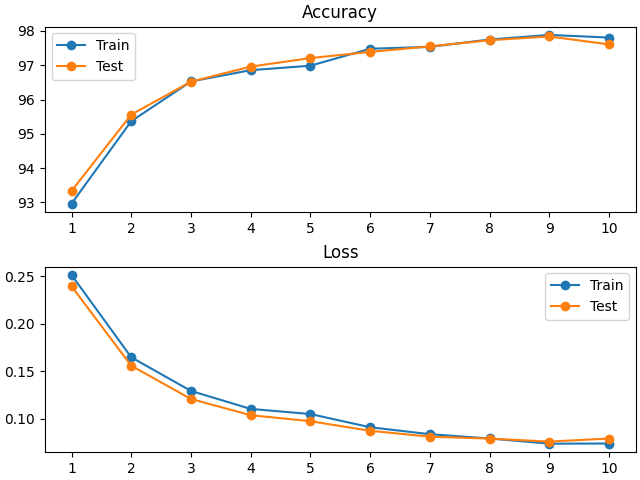

In [11]:
# You need to install ipympl to make this work
%matplotlib widget
from matplotlib import pyplot as plt


epochs = [i for i in range(1, NUMBER_OF_EPOCHS + 1)]
fig, axes = plt.subplots(2, 1, constrained_layout=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False


# Show accuracy
axes[0].plot(epochs, train_accuracy_per_epoch,'-o')
axes[0].plot(epochs, test_accuracy_per_epoch, '-o')
axes[0].set_xticks(epochs)
axes[0].legend(['Train', 'Test'])
axes[0].set_title('Accuracy')


# Show loss
axes[1].plot(epochs, train_loss_per_epoch,'-o')
axes[1].plot(epochs, test_loss_per_epoch, '-o')
axes[1].set_xticks(epochs)
axes[1].legend(['Train', 'Test'])
axes[1].set_title('Loss')


plt.show()

In [12]:
print(cnn_model)
print(f'Seed = {seed}')
print(f'Batch size = {BATCH_SIZE_TRAIN}')
print(f'Number of epochs = {NUMBER_OF_EPOCHS}')
print(f'Learning rate at start= {LEARNING_RATE}')

# Compute the accuracy of the model on the test dataset
loss = ComputeAccuracy(test_loader, 'test')

PR_CNN(
  (conv1): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(3, 3))
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 384, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1536, out_features=10, bias=True)
  )
)
Seed = 1649183043
Batch size = 32
Number of epochs = 10
Learning rate at start= 0.1
Accuracy test: 9761/10000 (97.61%)
Average loss: 0.0794

